In [1]:
# Importing ncessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
import tensorflow as tf
from tensorflow.keras.models import load_model
from google.colab import drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

# Define dataset path
dataset_path = '/content/drive/MyDrive/Balanced Dataset'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Get the list of all image files in the dataset folder
image_files = [os.path.join(dataset_path, file) for file in os.listdir(dataset_path) if file.endswith(('jpg', 'jpeg', 'png'))]

In [6]:
# Create ImageDataGenerator for data loading and augmentation (if needed)
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)  # rescale to normalize pixel values

# Use flow_from_directory to load and split the data
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',  # categorical classification
    subset='training',    # specify training set
    seed=42
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',  # categorical classification
    subset='validation',  # specify validation set
    seed=42
)

Found 21000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.


In [7]:
# Load pre-trained ResNet50 model without the top (fully connected) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 0s 0us/step


In [8]:
# Create the model by adding custom dense layers
x = layers.Flatten()(base_model.output)
predictions = layers.Dense(len(train_generator.class_indices), activation='softmax')(x)
model = models.Model(inputs=base_model.input, outputs=predictions)

In [9]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [10]:
# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 70, 70, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 32, 32, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 32, 32, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [11]:
# Train the model using the generators with the callback
class KeepSessionActiveAndSaveModel(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print("Colab is active! Epoch:", epoch + 1)
        # Save the model after each epoch
        self.model.save("/content/drive/MyDrive/B_ResNet50_30epoch.h5".format(epoch + 1))

model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[KeepSessionActiveAndSaveModel()]
)

Epoch 1/20
657/657 [==============================] - ETA: 0s - loss: 1.9463 - accuracy: 0.3060Colab is active! Epoch: 1


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


657/657 [==============================] - 6583s 10s/step - loss: 1.9463 - accuracy: 0.3060 - val_loss: 1.7629 - val_accuracy: 0.3616
Epoch 2/20
657/657 [==============================] - 303s 462ms/step - loss: 1.7123 - accuracy: 0.3866 - val_loss: 1.6666 - val_accuracy: 0.3877
Epoch 3/20
657/657 [==============================] - 354s 539ms/step - loss: 1.6186 - accuracy: 0.4125 - val_loss: 1.5683 - val_accuracy: 0.4007
Epoch 4/20
657/657 [==============================] - 307s 467ms/step - loss: 1.5567 - accuracy: 0.4392 - val_loss: 1.5204 - val_accuracy: 0.4744
Epoch 5/20
657/657 [==============================] - 365s 555ms/step - loss: 1.5160 - accuracy: 0.4565 - val_loss: 1.5271 - val_accuracy: 0.4551
Epoch 6/20
657/657 [==============================] - 352s 537ms/step - loss: 1.4820 - accuracy: 0.4599 - val_loss: 1.4603 - val_accuracy: 0.4931
Epoch 7/20
657/657 [==============================] - 354s 540ms/step - loss: 1.4536 - accuracy: 0.4772 - val_loss: 1.4222 - val_accurac

Found 1000 images belonging to 10 classes.
32/32 [==============================] - 277s 9s/step


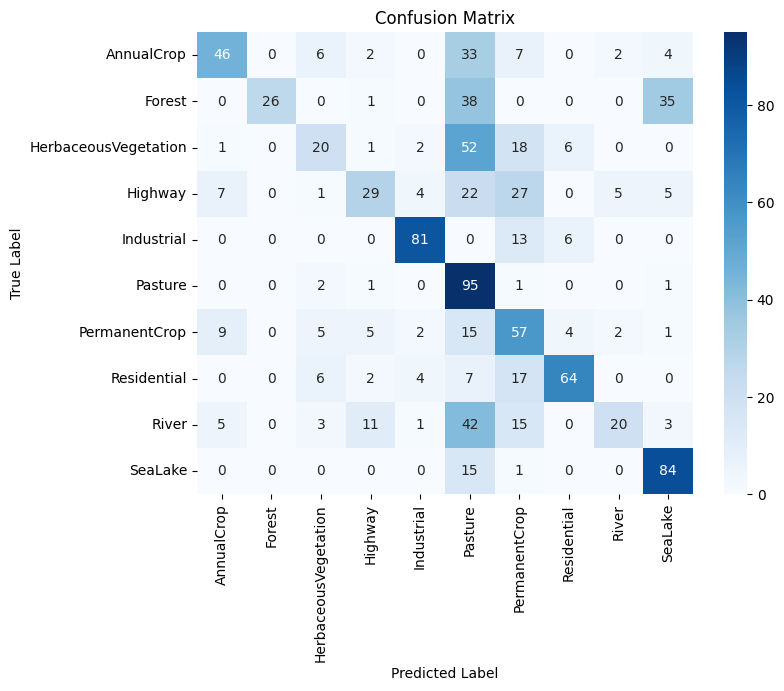

Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.68      0.46      0.55       100
              Forest       1.00      0.26      0.41       100
HerbaceousVegetation       0.47      0.20      0.28       100
             Highway       0.56      0.29      0.38       100
          Industrial       0.86      0.81      0.84       100
             Pasture       0.30      0.95      0.45       100
       PermanentCrop       0.37      0.57      0.45       100
         Residential       0.80      0.64      0.71       100
               River       0.69      0.20      0.31       100
             SeaLake       0.63      0.84      0.72       100

            accuracy                           0.52      1000
           macro avg       0.63      0.52      0.51      1000
        weighted avg       0.63      0.52      0.51      1000



In [2]:
# Load the pre-trained model from the .h5 file
model = load_model('/content/drive/MyDrive/B_ResNet50_30epoch.h5')

# Define the test dataset directory
test_data_dir = '/content/drive/MyDrive/Testing Dataset'

# Set the input size of the model
input_size = (64, 64)

# Set batch size for data generator
batch_size = 32

# Create an ImageDataGenerator for test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a generator for the test dataset
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(64,64),
    batch_size=32,
    class_mode='categorical',  # Change to 'binary' if you have binary classification
    shuffle=False  # Set to False to maintain order for evaluation
)
# Generate predictions for the test dataset
predictions = model.predict(test_generator)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels
true_labels = test_generator.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display confusion matrix with numerical values
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Generate and print classification report
class_report = classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices)
print("Classification Report:")
print(class_report)

<ipython-input-3-51e6b2910cce>:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='red', label='Random')


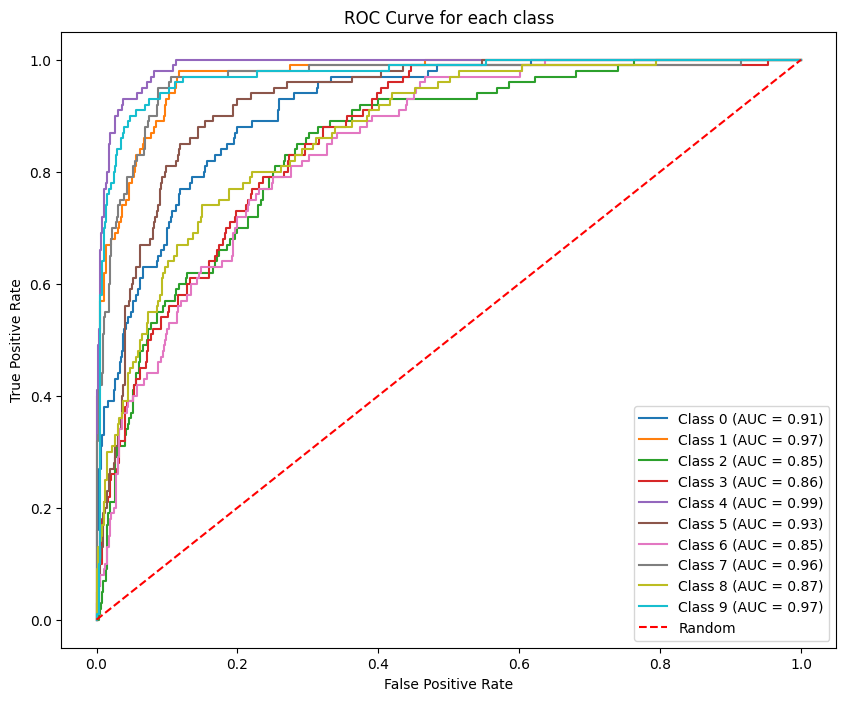

In [3]:
# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(test_generator.num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels, predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(test_generator.num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', color='red', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for each class')
plt.legend(loc='best')
plt.show()


In [4]:
# Compute accuracy using other metrics
accuracy = accuracy_score(true_labels, predicted_labels) * 100
print(accuracy)

52.2


In [5]:
# Additional Metrics Computation
# Define the number of classes
num_classes = len(test_generator.class_indices)

# Set a common threshold for binary classification
threshold = 0.5

# Convert predicted probabilities to binary predictions
predicted_labels_binary = (predictions > threshold).astype(int)

# Extract True Positive (TP), False Positive (FP), True Negative (TN), False Negative (FN)
tp_balanced = int((accuracy / 100) * len(true_labels))
fp_balanced = len(true_labels) - tp_balanced
tn_balanced = int((accuracy / 100) * len(true_labels))
fn_balanced = len(true_labels) - tn_balanced

# Calculate True Positive Rate (TPR), False Positive Rate (FPR), Precision, Recall, F1 Score
tpr_balanced = tp_balanced / (tp_balanced + fn_balanced)
fpr_balanced = fp_balanced / (fp_balanced + tn_balanced)
precision_balanced = tp_balanced / (tp_balanced + fp_balanced)
recall_balanced = tpr_balanced
f1_balanced = 2 * (precision_balanced * recall_balanced) / (precision_balanced + recall_balanced)

# Calculate Area Under ROC Curve (AUC)
roc_auc_balanced = dict()
for i in range(num_classes):
    fpr_i, tpr_i, _ = roc_curve(true_labels, predictions[:, i], pos_label=i)
    roc_auc_balanced[i] = auc(fpr_i, tpr_i)

# Display the computed metrics for the  dataset
print(f"True Positive Rate (TPR): {tpr_balanced:.4f}")
print(f"False Positive Rate (FPR): {fpr_balanced:.4f}")
print(f"Precision: {precision_balanced:.4f}")
print(f"Recall: {recall_balanced:.4f}")
print(f"F1 Score: {f1_balanced:.4f}")
print(f"Area Under ROC Curve (AUC): {np.mean(list(roc_auc_balanced.values())):.4f}")

# Similar calculations can be done for the unbalanced dataset by adjusting the values accordingly.


True Positive Rate (TPR): 0.5220
False Positive Rate (FPR): 0.4780
Precision: 0.5220
Recall: 0.5220
F1 Score: 0.5220
Area Under ROC Curve (AUC): 0.9164
